This workbook transforms the data from individual 1hz readings into a high 
level overview based on a track. 

This enables a data reduction of 86,400 --> 1 which significantly improves the 
ml loading

Load the data

In [1]:
import os
import datetime
from pathlib import Path
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

path = Path(r'/Users/sr2/OneDrive - University College London/PhD/Research/'
        'Missions/SWARM/Non-Flight Data/Analysis/Mar-22/data/solar_max/')

dir_suffix = '2014'
#pre_classified = str(path) + '/' + dir_suffix +'-data-2022-03-03.csv'
post_classified = str(path) + '/ml_model/SG-filtered_14-15.csv'

def open_all(filename):
    print('Loading data...')
    df = pd.read_csv(filename)
    return df

df = open_all(post_classified)

Loading data...


Feature Engineering

In [2]:
#Add deltas for moments

df['alt'] = (df.pop('alt')/1000) - 6371

df['ne_5'] = df['Ne'].pct_change(periods=5)
df['ne_10'] = df['Ne'].pct_change(periods=10)
df['ne_20'] = df['Ne'].pct_change(periods=20)

df['te_5'] = df['Te'].pct_change(periods=5)
df['te_10'] = df['Te'].pct_change(periods=10)
df['te_20'] = df['Te'].pct_change(periods=20)

#df['pot_5'] = df['pot'].pct_change(periods=5)
#df['pot_10'] = df['pot'].pct_change(periods=10)
#df['pot_20'] = df['pot'].pct_change(periods=20)

df['ti_5'] = df['Ti'].pct_change(periods=5)
df['ti_10'] = df['Ti'].pct_change(periods=10)
df['ti_20'] = df['Ti'].pct_change(periods=20)

#New time
df['datetime'] = df['date'] +' '+ df['utc']
date_time = pd.to_datetime(df.pop('datetime'), format='%Y-%m-%d %H:%M:%S')
df=df.dropna()
df.head()


,date,utc,mlt,lat,long,s_id,p_num,b_ind,b_prob,Ne,...,alt,ne_5,ne_10,ne_20,te_5,te_10,te_20,ti_5,ti_10,ti_20
20,2014-09-16,00:55:08,0.333374,32.400555,-15.371404,A,34,0,0.0,315190.2,...,467.01512,0.030647,0.059240,0.105916,-0.000119,0.000378,-0.001396,0.004835,0.007199,0.012713
21,2014-09-16,00:55:09,0.333029,32.336661,-15.371452,A,34,0,0.0,317273.1,...,467.02692,0.032655,0.059556,0.110061,0.000868,0.001419,-0.001237,0.004736,0.006346,0.011886
22,2014-09-16,00:55:10,0.332685,32.272766,-15.371506,A,34,0,0.0,319544.5,...,467.03872,0.034399,0.064108,0.111100,0.000119,-0.000761,0.000066,0.004650,0.007565,0.012083
23,2014-09-16,00:55:11,0.332340,32.208872,-15.371566,A,34,0,0.0,321832.6,...,467.05053,0.034952,0.065659,0.114620,-0.000808,-0.000702,-0.001714,0.003757,0.007643,0.011745
24,2014-09-16,00:55:12,0.331995,32.144977,-15.371632,A,34,0,0.0,323501.1,...,467.06234,0.033169,0.063428,0.116605,0.000232,0.001014,-0.000430,0.002422,0.007083,0.011703


Add Kp, DST & 10.7 dummy values

In [3]:
df_len = df.shape[0]
Kp = np.linspace(-7, 7, num=df_len)
dst = np.linspace(-200, 200, num=df_len)
ten_7 = np.linspace(25, 300, num=df_len)
df['Kp'] = Kp
df['dst'] = dst
df['107'] = ten_7

In [4]:
#Convert time into into a signal
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60 #hr, min, sec
year = (365.245)*day

df['d_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['d_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['y_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['y_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

'''
plt.plot(np.array(df['Day sin'])[::86400])
plt.plot(np.array(df['Day cos'])[::86400])
plt.xlabel('Time [h]')
plt.title('Time of day signal')'''

"\nplt.plot(np.array(df['Day sin'])[::86400])\nplt.plot(np.array(df['Day cos'])[::86400])\nplt.xlabel('Time [h]')\nplt.title('Time of day signal')"

In [5]:
#Convert lat and long into radians
df['lat'] = df.pop('lat')*np.pi / 180
df['long'] = df.pop('long')*np.pi / 180

'''
plt.plot(np.array(df['lat'])[::80000])
plt.plot(np.array(df['long'])[::80000])
plt.xlabel('Steps')
plt.title('Lat Long Signal')'''

"\nplt.plot(np.array(df['lat'])[::80000])\nplt.plot(np.array(df['long'])[::80000])\nplt.xlabel('Steps')\nplt.title('Lat Long Signal')"

In [6]:
#df.shape
#remove old values
df.drop(columns=['utc','b_ind','b_prob','sg_epb','Ne_pc','Ne_stddev'])
pd.set_option('display.max_rows',  None) #or 10 or None
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mlt,1883661.0,1.701561e+01,8.505357,1.203115e-06,19.077634,21.022853,22.329354,2.400000e+01
p_num,1883661.0,1.794279e+03,985.073704,2.000000e+00,919.000000,1787.000000,2644.000000,3.528000e+03
b_ind,1883661.0,3.683996e-02,0.188369,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
b_prob,1883661.0,2.850222e-02,0.157728,0.000000e+00,0.000000,0.000000,0.000000,9.909435e-01
Ne,1883661.0,4.751214e+05,436702.479968,7.910000e+02,149795.500000,320613.900000,672020.600000,3.114226e+06
Ne_std,1883661.0,1.389075e-02,0.096332,5.691376e-05,0.001027,0.002020,0.004246,1.529460e+01
Ti,1883661.0,1.210593e+03,157.397160,7.250300e+02,1104.120000,1223.920000,1330.110000,2.178510e+03
Ti_std,1883661.0,3.035581e-03,0.012806,2.232638e-05,0.000391,0.000584,0.000965,6.218901e-01
pot,1883661.0,-9.993918e-01,0.255212,-6.369000e+00,-1.137000,-0.962000,-0.801000,2.336000e+00
pot_std,1883661.0,1.712637e-02,3.917300,0.000000e+00,0.000510,0.000662,0.001027,1.686500e+03


Transform the data from 1hz to statistical overview of a pass. 86k --> 1

In [7]:
def transform_df(df):

    def groupby(df, feat, func_n, rename_col):
        func = getattr(df.groupby(['date','p_num'], as_index=False)[feat], func_n)
        df = func().rename(columns={feat:rename_col}).drop(columns=['date','p_num'])
        
        return df

    #min
    ne_min = df.groupby(['date','p_num'], as_index=False)['Ne'].min().rename(
            columns={'Ne':'ne_min'}) #unique. Because need the date and
    ti_min = groupby(df,'Ti','min','ti_min')
    pot_min = groupby(df,'pot','min','pot_min')
    te_min = groupby(df,'Te','min','te_min')

    #max
    ne_max = groupby(df,'Ne', 'max', 'ne_max')
    ti_max = groupby(df, 'Ti','max', 'ti_max')
    pot_max = groupby(df,'pot','max','pot_max')
    te_max = groupby(df,'Te','max','te_max')

    #mean
    ne_mean = groupby(df, 'Ne', 'mean', 'ne_mean')
    ti_mean = groupby(df, 'Ti', 'mean', 'ti_mean')
    pot_mean = groupby(df,'pot','mean','pot_mean')
    te_mean = groupby(df,'Te','mean','te_mean')

    #stddev
    ne_std = groupby(df, 'Ne', 'std', 'ne_std')
    ti_std = groupby(df, 'Ti', 'std', 'ti_std')
    pot_std = groupby(df,'pot','std','pot_std')
    te_std = groupby(df,'Te','std','te_std')

    #delta 
    ne_5 = groupby(df, 'ne_5', 'max', 'ne_5')
    ne_10 = groupby(df, 'ne_10', 'max', 'ne_10')
    ne_20 = groupby(df, 'ne_20', 'max', 'ne_20')

    te_5 = groupby(df, 'te_5', 'max', 'te_5')
    te_10 = groupby(df, 'te_10', 'max', 'te_10')
    te_20 = groupby(df, 'te_20', 'max', 'te_20')

    ti_5 = groupby(df, 'ti_5', 'max', 'ti_5')
    ti_10 = groupby(df, 'ti_5', 'max', 'ti_10')
    ti_20 = groupby(df, 'ti_5', 'max', 'ti_20')

    #"Header" info
    #normal
    lat = groupby(df, 'lat', 'mean', 'lat')
    lon = groupby(df, 'long', 'mean', 'long')
    mlt = groupby(df, 'mlt', 'mean', 'mlt')
    alt = groupby(df, 'alt', 'mean', 'alt')

    #fequencies
    d_sin = groupby(df, 'd_sin', 'mean', 'd_sin')
    d_cos = groupby(df, 'd_cos', 'mean', 'd_cos')
    y_sin = groupby(df, 'y_sin', 'mean', 'y_sin')
    y_cos = groupby(df, 'y_cos', 'mean', 'y_cos')


    #EPB
    #ibi_epb = groupby(df, 'b_ind', 'max', 'IBI')
    mssl_epb = groupby(df, 'sg_smooth','max','epb')
    #ibi_size = groupby(df, 'b_ind', 'sum', 'ibi_size')
    mssl_size = groupby(df, 'sg_smooth', 'sum', 'epb_size')
    
    def epb_size_cal(df,col):
        df[col] = df[col] * 7.7
        return df
    
    #ibi_size = epb_size_cal(ibi_size, 'ibi_size')
    mssl_size = epb_size_cal(mssl_size, 'epb_size')

    #Non-SWARM inputs
    Kp = groupby(df, 'Kp', 'mean', 'Kp')
    dst = groupby(df, 'dst', 'mean', 'dst')
    ten_7 = groupby(df, '107', 'mean', '107')

    df = pd.concat([
        lat, lon, mlt, alt,
        d_sin, d_cos, y_sin, y_cos,
        ne_min, ne_max, ne_mean, ne_std,
        pot_min, pot_max, pot_mean, pot_std,
        ti_min, ti_max, ti_mean, ti_std,
        te_min, te_max, te_mean, te_std,
        ne_5, ne_10, ne_20, te_5, te_10, te_20, ti_5, ti_10, ti_20,
        #Kp, dst, ten_7,
        #ne_del, pot_del, ti_del,
        #ibi_epb, ibi_size, 
        mssl_size, mssl_epb], axis=1)

    df = df.sort_values(by=['date','p_num'], ascending=[True,True])

    return df

pd.set_option('display.max_rows',  None) #or 10 or None


df_gb = transform_df(df)
df_gb.drop(columns=['date','p_num'])
df_gb.head(10)


,lat,long,mlt,alt,d_sin,d_cos,y_sin,y_cos,date,p_num,...,ne_10,ne_20,te_5,te_10,te_20,ti_5,ti_10,ti_20,epb_size,epb
0,0.490663,-1.297054,20.059348,486.821497,0.309041,0.951042,0.512357,0.858773,2014-02-01,2838,...,0.045535,0.079026,0.712794,0.725945,0.745595,0.003443,0.003443,0.003443,0.0,0
1,-0.075300,-1.306930,19.978584,492.141427,0.344017,0.938758,0.512444,0.858721,2014-02-01,2839,...,6.882411,7.484079,1.829199,1.231378,1.833173,0.434945,0.434945,0.434945,1809.5,1
2,0.112872,-1.716866,19.926068,490.587296,0.681905,0.731105,0.513383,0.858160,2014-02-01,2841,...,1.623682,2.083935,1.036994,1.039595,1.043940,0.708490,0.708490,0.708490,531.3,1
3,0.139017,-2.129635,19.937049,490.422942,0.916785,0.398745,0.514346,0.857583,2014-02-01,2843,...,2.459978,2.833119,1.070184,1.064463,1.878037,0.403777,0.403777,0.403777,215.6,1
4,0.165121,-2.542287,20.033945,490.143321,0.999728,0.000316,0.515308,0.857005,2014-02-01,2845,...,2.244297,2.398635,1.049017,1.327103,1.521660,0.564149,0.564149,0.564149,377.3,1
5,0.206794,-2.954857,20.117453,489.715827,0.917433,-0.397223,0.516267,0.856428,2014-02-01,2847,...,2.990015,3.252778,0.894943,0.988839,0.981639,0.334029,0.334029,0.334029,338.8,1
6,0.160862,2.914247,20.160647,490.088091,0.679662,-0.733180,0.517239,0.855841,2014-02-01,2849,...,3.817943,4.272812,2.224595,2.057068,2.107303,0.371885,0.371885,0.371885,492.8,1
7,0.138995,2.500679,20.181363,490.184718,0.328176,-0.944355,0.518207,0.855255,2014-02-01,2851,...,4.725375,5.121587,2.178839,1.614342,1.932571,0.344438,0.344438,0.344438,500.5,1
8,0.050936,2.085916,20.281656,491.013949,-0.082850,-0.996364,0.519184,0.854663,2014-02-01,2853,...,13.022579,13.872650,0.999669,1.030375,1.486081,0.431273,0.431273,0.431273,770.0,1
9,0.155043,1.674614,20.304382,490.142506,-0.468590,-0.883201,0.520131,0.854087,2014-02-01,2855,...,4.387347,5.115322,0.609248,0.985736,1.042658,0.325010,0.325010,0.325010,184.8,1


In [18]:

df_gb = df_gb.drop(columns=['lat','p_num','date'])
df_gb.replace([np.inf, -np.inf], np.nan, inplace=True)
df_gb.describe().transpose()
#df_gb.shape

,count,mean,std,min,25%,50%,75%,max
long,2588.0,0.013620,1.784640,-3.133908,-1.489253,0.007232,1.548868e+00,3.131544e+00
mlt,2588.0,17.158374,7.980877,0.053989,17.738061,20.879602,2.218727e+01,2.396825e+01
alt,2588.0,468.623628,6.901139,452.895547,464.469014,468.377113,4.723511e+02,4.963093e+02
d_sin,2588.0,-0.007206,0.701547,-0.999999,-0.709049,-0.014140,6.985379e-01,9.999849e-01
d_cos,2588.0,0.022631,0.712253,-0.999985,-0.686292,0.041267,7.414240e-01,9.999957e-01
y_sin,2588.0,-0.196751,0.860134,-1.000000,-0.971241,-0.909288,7.480348e-01,9.774612e-01
y_cos,2588.0,0.279256,0.379232,-0.503464,0.016501,0.333078,5.740362e-01,8.587725e-01
ne_min,2588.0,130177.749845,114410.696728,791.000000,69916.950000,103024.000000,1.487164e+05,1.251022e+06
ne_max,2588.0,983721.860510,686669.932042,32797.900000,382492.775000,891595.750000,1.460070e+06,3.114226e+06
ne_mean,2588.0,445029.523441,273851.082441,25104.501911,209193.139821,423828.500434,6.400707e+05,1.934457e+06


Visualise the Data

<AxesSubplot:>

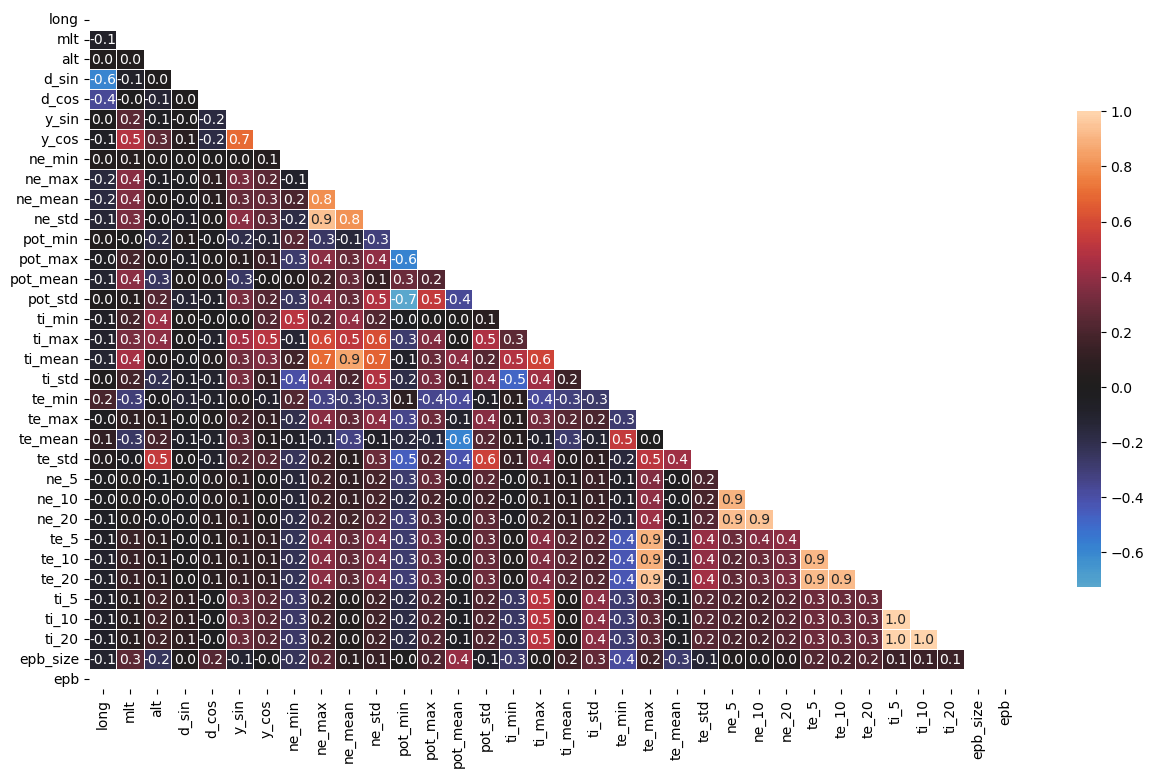

In [9]:
#heatmap

#df_gb.pop('date')
#corr_df = df_gb.drop(columns=['lat','p_num'])
corr_df = df_gb[df_gb['epb'] == 1]
corr_df = corr_df.corr()

plt.figure(figsize=(15,9), dpi=100)
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, center=0, mask=mask, cbar_kws={"shrink": .7},
        square=False, linewidths=0.5, annot=True, fmt=".1f")

Visualise distribution


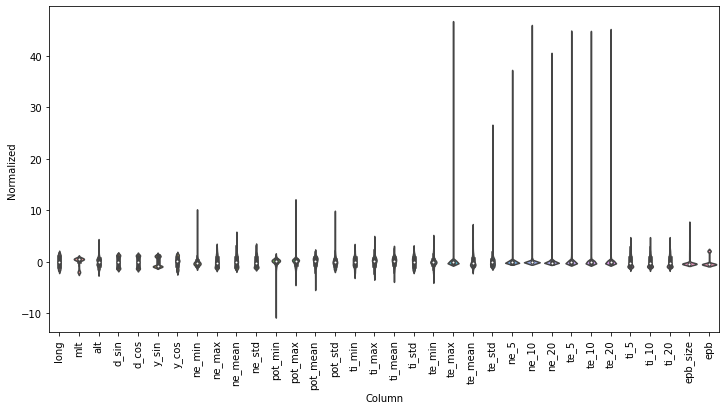

In [10]:
df_std = df_gb.std()
df_mean = df_gb.mean()
df_violin = (df_gb - df_mean) / df_std
df_violin = df_violin.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_violin)
_ = ax.set_xticklabels(df_gb.keys(), rotation=90)

In [78]:
#Address long tails
df_tails = df_gb
df_tails['te_max'] = df_tails['te_max'].where(df_tails['te_max'] < 5000, df_tails['te_max'].mean())
df_tails['te_std'] = df_tails['te_std'].where(df_tails['te_std'] < 1000, df_tails['te_std'].mean())
df_tails['ne_5'] = df_tails['ne_5'].where(df_tails['ne_5'] < 50, 50)
df_tails['ne_10'] = df_tails['ne_10'].where(df_tails['ne_10'] < 100, 100)
df_tails['ne_20'] = df_tails['ne_20'].where(df_tails['ne_20'] < 200, 200)
df_tails['te_5'] = df_tails['te_5'].where(df_tails['te_5'] < 5, 5)
df_tails['te_10'] = df_tails['te_10'].where(df_tails['te_10'] < 3, 3)
df_tails['te_20'] = df_tails['te_20'].where(df_tails['te_20'] < 3, 3)
#df_tails['ne_5'] = df_tails['ne_5'].where(df_tails['ne_5'] < 100, df_tails['ne_5'].mean())
df_tails.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
long,2588.0,0.013620,1.784640,-3.133908,-1.489253,0.007232,1.548868e+00,3.131544e+00
mlt,2588.0,17.158374,7.980877,0.053989,17.738061,20.879602,2.218727e+01,2.396825e+01
alt,2588.0,468.623628,6.901139,452.895547,464.469014,468.377113,4.723511e+02,4.963093e+02
d_sin,2588.0,-0.007206,0.701547,-0.999999,-0.709049,-0.014140,6.985379e-01,9.999849e-01
d_cos,2588.0,0.022631,0.712253,-0.999985,-0.686292,0.041267,7.414240e-01,9.999957e-01
y_sin,2588.0,-0.196751,0.860134,-1.000000,-0.971241,-0.909288,7.480348e-01,9.774612e-01
y_cos,2588.0,0.279256,0.379232,-0.503464,0.016501,0.333078,5.740362e-01,8.587725e-01
ne_min,2588.0,130177.749845,114410.696728,791.000000,69916.950000,103024.000000,1.487164e+05,1.251022e+06
ne_max,2588.0,983721.860510,686669.932042,32797.900000,382492.775000,891595.750000,1.460070e+06,3.114226e+06
ne_mean,2588.0,445029.523441,273851.082441,25104.501911,209193.139821,423828.500434,6.400707e+05,1.934457e+06


Text(0.5, 0, ' ')

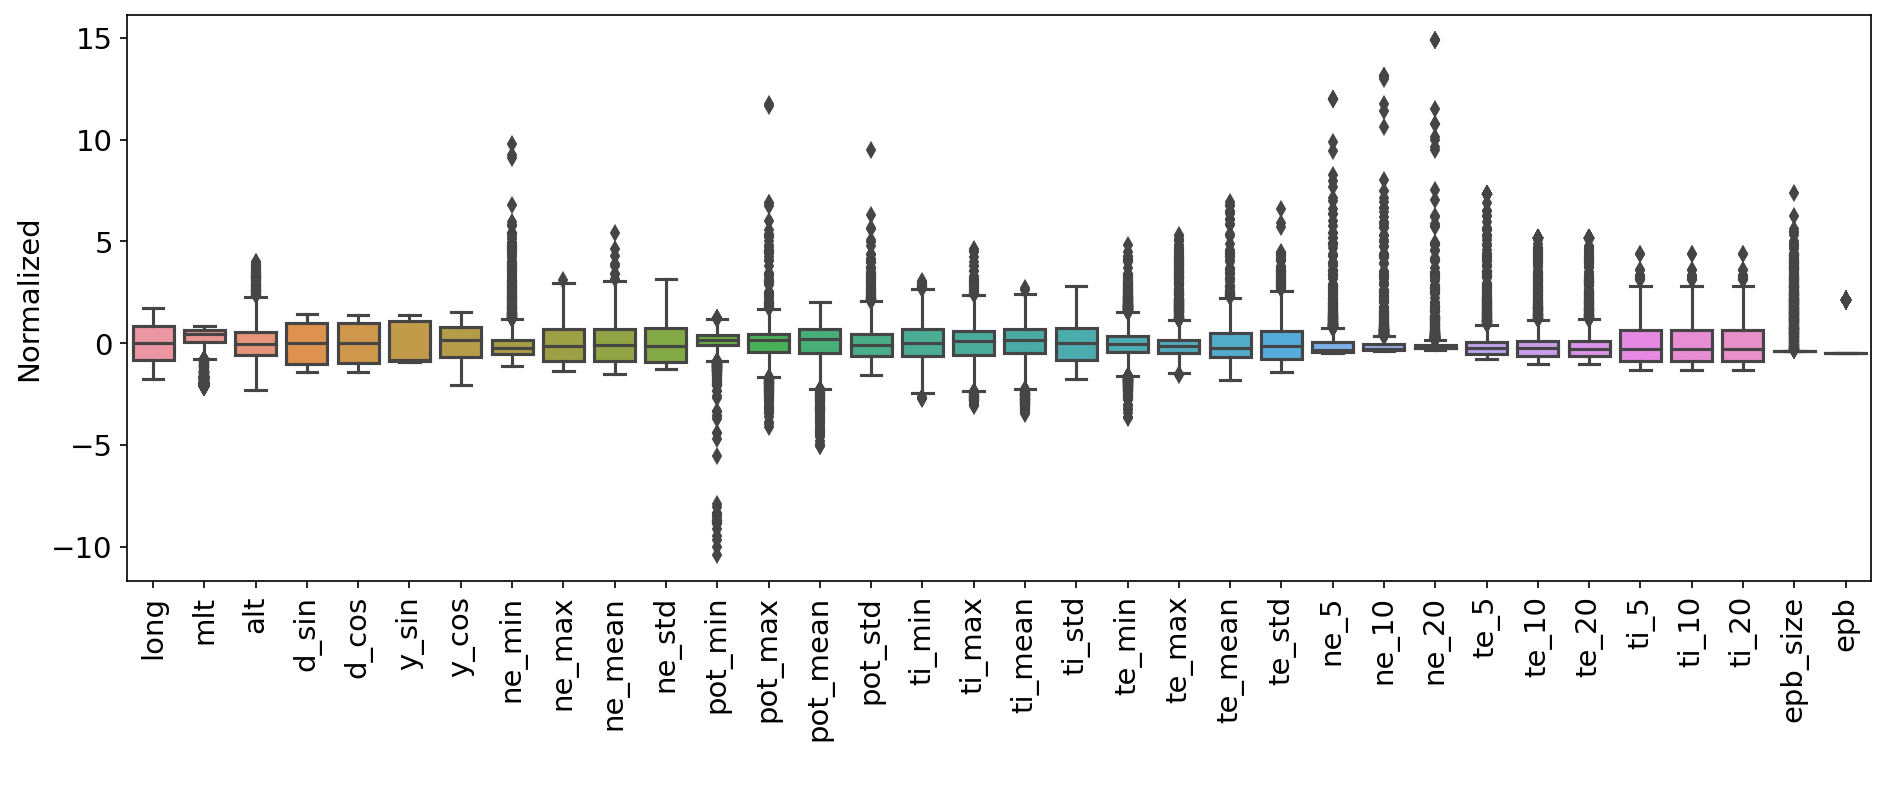

In [106]:
df_std = df_tails.std()
df_mean = df_tails.mean()
df_violin = (df_tails - df_mean) / df_std
df_violin = df_violin.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(15, 5), dpi=150)
plt.rc('font', size=14) 
ax = sns.boxplot(x='Column', y='Normalized', data=df_violin)
_ = ax.set_xticklabels(df_tails.keys(), rotation=90)
plt.xlabel(' ')

<AxesSubplot:xlabel='epb', ylabel='pot_max'>

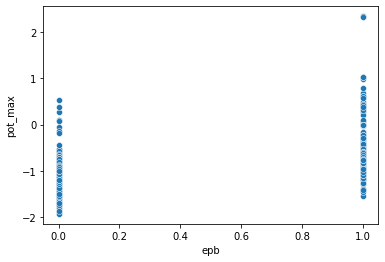

In [94]:
sns.scatterplot(data=df_tails, x='epb', y='pot_max')

Export

Now we export ready for ml

In [13]:
df_name = 'LSTM_37-feats.csv'
df_gb.to_csv(df_name, index=False, header=True)
print('df exported')

df exported
